In [288]:
import numpy as np
import tulipy as ti
import pandas_datareader.data as web
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math as m
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn import svm

In [289]:
style.use('ggplot')
# Date information
start_date = datetime.datetime(2000,1,1)
end_date = datetime.datetime(2021,12,1)
# Stock symbols
stock_symbols = pd.read_csv("tickers.csv", names = ["symbols"])
current_stock = stock_symbols.symbols[10]
print(current_stock)
# High Low Open Close data about the stock chosen
data = web.DataReader(current_stock, "yahoo", start_date, end_date)

ABB


In [290]:
def np_attributes(df):
    """
    Changed each column to numpy arrays
    [ high, low, close, volume, open]
    """
    close = df.Close.to_numpy(dtype = "float")
    volume = df.Volume.to_numpy(dtype = "float")
    high = df.High.to_numpy(dtype = "float")
    low = df.Low.to_numpy(dtype = "float")
    Open = df.Open.to_numpy(dtype = "float")
    return [high,low, close, volume, Open]

In [291]:
def simple_moving_average(df, period):
    """
    DOES CHANGE SIZE MAKES NEW DF
    df - pandas dataframe
    period - how much the moving average is measured on
    return -  dataframe with simple moving average in it
    """
    np_vals = np_attributes(df)
    changed_df = df
    sma = ti.sma(np_vals[2], period)
    changed_df = changed_df.drop(changed_df.index[0:period-1])        
    changed_df["SMA"] = sma
    return changed_df

def accumulation_line(df, high, low, close, volume):
    """
    DOES NOT CHANGE SIZE ADDS TO GIVEN DF
    numpy arrays with the respective values and a
    pandas dataframe
    return - the dataframe with the accumulation line
    """
    ad = ti.ad(high, low, close, volume)
    df["AC Line"] = ad
    return df

def target_column(df, threshold, period):
    """DOES CHANGE SIZE OF DATAFRAME
        Makes target labels of 0 and 1
        depending on the threshold and period. 
        Both the threshold and period are ints
        
        Returns - the dataframe given (now smaller)
        with the target column in it
    """
    target = []
    profits = []
    i = 0
    while i<df.Close.shape[0]:
        if i+period >= df.Close.shape[0]:
            break
        profit =(df.Close[i]-df.Close[i+period])/df.Close[i]
        if profit<threshold:
            target.append(0)
            profits.append(profit)
        else:
            target.append(1)
            profits.append(profit)
        i+=1
    df = df.drop(df.index[-period:df.Close.size])
    df["Target"] = target
    return df

def fishers_transform(df, high, low, period = 0):
    """ CHANGES SIZE 
        INPUT - HIGH LOW, PERIOD
        OUTPUT - fisher_transfrom and its singal in the
        given dataframe
    
    """
    changed_df = df
    fisher,fisher_signal = ti.fisher(high, low, period)
    changed_df = changed_df.drop(changed_df.index[0:period-1])
    changed_df["fisher"] = fisher
    changed_df["fisher signal"] = fisher_signal
    return changed_df

def balance_of_power(df, high, low, Open, close):
    """Does not change size"""
    
    balance = ti.bop(Open, high, low, close)
    df["BalanceOP"] = balance
    return df

def macd(df, short, long, signal):
    changed_df = df
    macd, macd_signal, macd_histogram = ti.macd(df.Close.to_numpy(), short, long, signal)
    changed_df = changed_df.drop(changed_df.index[0:long-1])
    changed_df["macd"] = macd
    changed_df["macd signal"] = macd_signal
    changed_df["macd histogram"] = macd_histogram
    return changed_df
    
    

In [292]:
data = simple_moving_average(data,100)
attri =np_attributes(data)
data = accumulation_line(data, attri[0], attri[1],attri[2],attri[3])
data = fishers_transform(data,attri[0],attri[1], 5)
attri =np_attributes(data)
data = balance_of_power(data,attri[0], attri[1], attri[4], attri[2])
attri =np_attributes(data)
data = macd(data, 21,51,54)
df = target_column(data, 0.01, 5)
print(df)

                 High        Low       Open      Close     Volume  Adj Close  \
Date                                                                           
2001-11-19  11.230000  11.000000  11.050000  11.150000   112300.0   5.587222   
2001-11-20  11.000000  10.220000  10.700000  11.000000   118200.0   5.512058   
2001-11-21  10.850000  10.300000  10.850000  10.700000    43700.0   5.361729   
2001-11-23  11.600000  11.250000  11.520000  11.300000    18000.0   5.662386   
2001-11-26  11.350000  11.010000  11.200000  11.300000    16500.0   5.662386   
...               ...        ...        ...        ...        ...        ...   
2021-11-17  35.700001  35.500000  35.639999  35.650002  1091300.0  35.650002   
2021-11-18  35.700001  35.520000  35.650002  35.689999   730000.0  35.689999   
2021-11-19  35.980000  35.709999  35.770000  35.740002  1065400.0  35.740002   
2021-11-22  36.080002  35.619999  35.900002  35.619999  1129400.0  35.619999   
2021-11-23  35.779999  35.369999  35.590

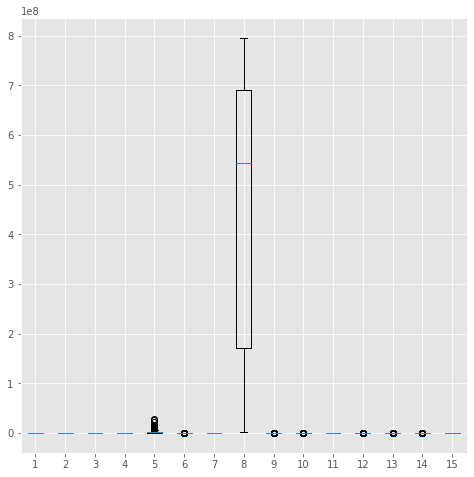

In [293]:
# looking at the data before any operations are made
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(1,1,1)
ax.boxplot(df);

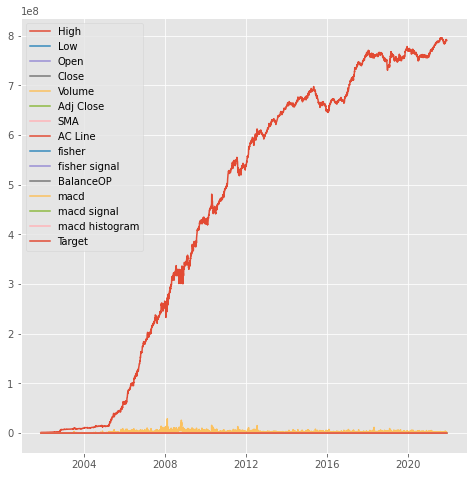

In [294]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(1,1,1)
ax.plot(df)
ax.legend(df.columns);

In [295]:
x = df.loc[:, ["High","Low", "Close", "Volume", "SMA", "AC Line", "fisher", "fisher signal",
              "BalanceOP","macd", "macd signal", "macd histogram"]]
y = df.loc[:, ['Target']]

# normalising manually
x = x.to_numpy()
mu = np.mean(x, 0)
sigma = np.std(x, 0)
x = (x - mu) / sigma

y = y.to_numpy()

x_train = x[0:m.floor(x.shape[0] * 0.9)]
y_train = y[0:m.floor(y.shape[0]*0.9)]
x_test = x[m.ceil(x.shape[0] * 0.9):x.shape[0]]
y_test = y[m.ceil(y.shape[0] * 0.9):y.shape[0]]

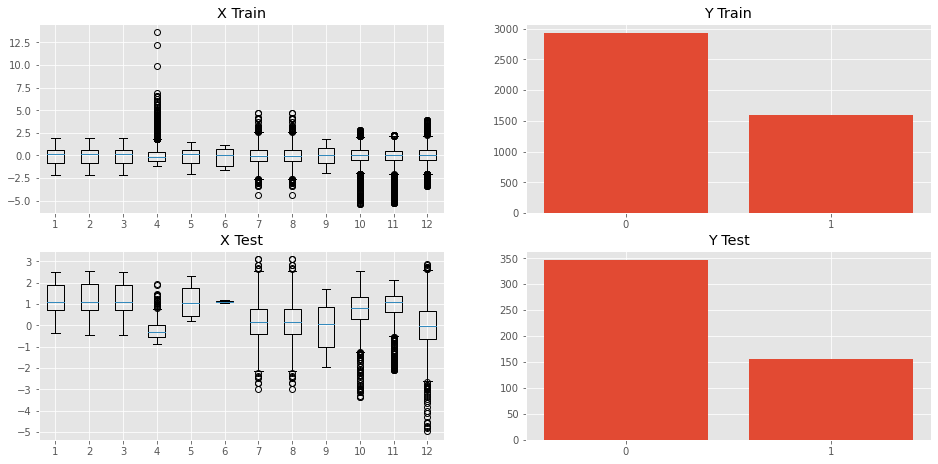

In [296]:
fig = plt.figure(figsize=[16,16])
ax = fig.add_subplot(4,2,1)
ax.boxplot(x_train)
ax.set_title("X Train");

ax = fig.add_subplot(4,2,2)
(u, c) = np.unique(y_train, return_counts=True)
ax.bar(u, c)
ax.set_xticks(u)
ax.set_title("Y Train");

ax = fig.add_subplot(4,2,3)
ax.boxplot(x_test)
ax.set_title("X Test");

ax = fig.add_subplot(4,2,4)
(u, c) = np.unique(y_test, return_counts=True)
ax.bar(u, c)
ax.set_xticks(u)
ax.set_title("Y Test");

In [303]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(1,12)))
model.add(tf.keras.layers.Dense(1028, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

In [304]:
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 1, 1028)           13364     
_________________________________________________________________
dropout_71 (Dropout)         (None, 1, 1028)           0         
_________________________________________________________________
dense_87 (Dense)             (None, 1, 512)            526848    
_________________________________________________________________
dropout_72 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
dense_88 (Dense)             (None, 1, 512)            262656    
_________________________________________________________________
dropout_73 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
dense_89 (Dense)             (None, 1, 256)          

In [ ]:
adam = model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
his = model.fit(x_train, y_train, epochs=30, validation_data = (x_test,y_test))

Epoch 1/30
142/142 [==============================] - 2s 8ms/step - loss: 0.6598 - accuracy: 0.6441 - val_loss: 0.6255 - val_accuracy: 0.6799
Epoch 2/30
142/142 [==============================] - 1s 6ms/step - loss: 0.6509 - accuracy: 0.6459 - val_loss: 0.6422 - val_accuracy: 0.6899
Epoch 3/30
142/142 [==============================] - 1s 7ms/step - loss: 0.6456 - accuracy: 0.6476 - val_loss: 0.6488 - val_accuracy: 0.6322
Epoch 4/30
142/142 [==============================] - 1s 6ms/step - loss: 0.6386 - accuracy: 0.6514 - val_loss: 0.6502 - val_accuracy: 0.6899
Epoch 5/30
142/142 [==============================] - 1s 6ms/step - loss: 0.6396 - accuracy: 0.6553 - val_loss: 0.6457 - val_accuracy: 0.6819
Epoch 6/30
142/142 [==============================] - 1s 6ms/step - loss: 0.6384 - accuracy: 0.6534 - val_loss: 0.6504 - val_accuracy: 0.6839
Epoch 7/30
142/142 [==============================] - 1s 7ms/step - loss: 0.6347 - accuracy: 0.6587 - val_loss: 0.6504 - val_accuracy: 0.6740
Epoch 

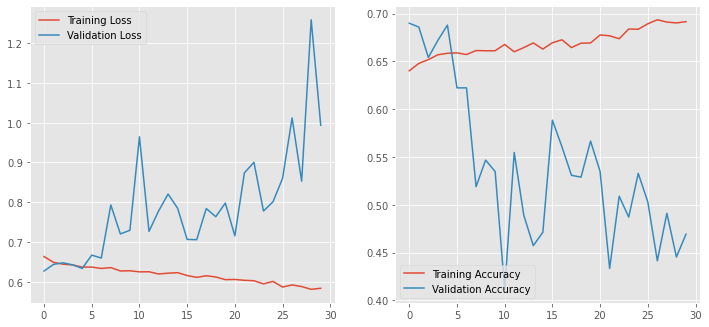

In [302]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(2,2,1)
ax.plot(his.history["loss"], label="Training Loss")
ax.plot(his.history["val_loss"], label="Validation Loss")
ax.legend();

ax = fig.add_subplot(2,2,2)
ax.plot(his.history["accuracy"], label="Training Accuracy")
ax.plot(his.history["val_accuracy"], label="Validation Accuracy")
ax.legend();

In [240]:
start_date = datetime.datetime(2021,12,2)
end_date = datetime.datetime(2022,1,11)
# Stock symbols
stock_symbols = pd.read_csv("tickers.csv", names = ["symbols"])
current_stock = stock_symbols.symbols[10]
# High Low Open Close data about the stock chosen
data = web.DataReader(current_stock, "yahoo", start_date, end_date)

In [241]:
data = simple_moving_average(data,3)
attri =np_attributes(data)
data = accumulation_line(data, attri[0], attri[1],attri[2],attri[3])
data = fishers_transform(data,attri[0],attri[1], 2)
attri =np_attributes(data)
data = balance_of_power(data,attri[0], attri[1], attri[4], attri[2])


In [249]:

x = data.loc[:, ["High","Low", "Close", "Volume", "SMA", "AC Line", "fisher", "fisher signal",
              "BalanceOP"]]

# normalising manually
x = x.to_numpy()
mu = np.mean(x, 0)
sigma = np.std(x, 0)
x = (x - mu) / sigma
predictions = model.predict([x])
j = 0
while j<predictions.shape[0]:
    print("predicted: ",np.argmax(predictions[j]))
    print("actual: ",np.argmax(x[j][0]))
    j+=1

predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  1
actual:  0
predicted:  0
actual:  0
predicted:  1
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  1
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  1
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0
predicted:  0
actual:  0


In [243]:
data.Close

Date
2021-12-06    36.119999
2021-12-07    36.270000
2021-12-08    36.799999
2021-12-09    36.720001
2021-12-10    36.730000
2021-12-13    36.689999
2021-12-14    36.180000
2021-12-15    36.790001
2021-12-16    37.389999
2021-12-17    36.759998
2021-12-20    36.560001
2021-12-21    37.000000
2021-12-22    37.009998
2021-12-23    37.770000
2021-12-27    38.270000
2021-12-28    38.380001
2021-12-29    38.650002
2021-12-30    38.139999
2021-12-31    38.169998
2022-01-03    38.470001
2022-01-04    39.000000
2022-01-05    38.430000
2022-01-06    38.270000
2022-01-07    38.099998
2022-01-10    36.779999
2022-01-11    37.419998
Name: Close, dtype: float64

In [194]:
# K nearest Neighbours
n=1
best_n = 1
best_acc = 0
while n<50:
    knn_model = KNeighborsClassifier(n_neighbors = n)
    knn_model.fit(x_train, y_train)
    predictions = knn_model.predict(x_test)
    i = 0
    total = 0
    correct = 0
    cor = []
    inc = []
    tot = []
    while i<len(predictions):
        if (predictions[i] == y_test[i] and predictions[i] == 1):
            total+=1
            correct+=1
            cor.append(y_test[i])
        elif predictions[i] == 1 and y_test[i]!= 1:
            total+=1
            inc.append(y_test[i])
        elif y_test[i] == 1:
            tot.append(y_test[i])
            total+=1
        i+=1
        
    if len(cor) == 0 or len(tot)==0:
        continue        
    else:
        acc = len(cor)/len(tot)
    if best_n == 1:
        best_n = n
        best_acc = acc
    elif best_acc < acc:
        best_acc = acc            
        best_n = n
    n+=1
print(best_acc, best_n)

/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1

/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1

1.2941176470588236 3


/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [195]:
parameters = {"weights": ["uniform", "distance"]}
gridsearch = GridSearchCV(KNeighborsClassifier(n_neighbors = best_n), parameters)
gridsearch.fit(x_train, y_train)
predictions = gridsearch.predict(x_test)

/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/pentaflouride/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1

In [197]:
i = 0
total = 0
correct = 0
cor = []
inc = []
tot = []
    
while i<len(predictions):
    if (np.argmax(predictions[i]) == y_test[i] and np.argmax(predictions[i]) == 1):
            #print ((predictions[i], y_test[i]))
        total+=1
        correct+=1
        cor.append(y_test[i])
    elif np.argmax(predictions[i]) == 1 and y_test[i]!= 1:
        total+=1
        inc.append(y_test[i])
    elif y_test[i] == 1:
        tot.append(y_test[i])
        total+=1
    i+=1
        
acc = len(cor)/len(tot)
acc

0.0